In [1]:
%load_ext line_profiler

import numpy as np
import sys
sys.path.insert(0, "../")
from pygraph.utils.utils import kernel_train_test
from pygraph.kernels.weisfeilerLehmanKernel import weisfeilerlehmankernel, _wl_subtreekernel_do

datafile = '../../../../datasets/acyclic/Acyclic/dataset_bps.ds'
kernel_file_path = 'kernelmatrices_weisfeilerlehman_subtree_acyclic/'

kernel_para = dict(node_label = 'atom', edge_label = 'bond_type')

kernel_train_test(datafile, kernel_file_path, weisfeilerlehmankernel, kernel_para, \
    hyper_name = 'height', hyper_range = np.linspace(0, 10, 11), normalize = False)

# %lprun -f _wl_subtreekernel_do \
#     kernel_train_test(datafile, kernel_file_path, weisfeilerlehmankernel, kernel_para, \
#     hyper_name = 'height', hyper_range = np.linspace(0, 10, 11), normalize = False)


 --- This is a regression problem ---


 #--- calculating kernel matrix when height = 0.0 ---#

 Loading dataset from file...

 Calculating kernel matrix, this could take a while...

 --- Weisfeiler-Lehman subtree kernel matrix of size 185 built in 0.38979601860046387 seconds ---
[[   5.    6.    4. ...,   20.   20.   20.]
 [   6.    8.    4. ...,   20.   20.   20.]
 [   4.    4.    5. ...,   21.   21.   21.]
 ..., 
 [  20.   20.   21. ...,  101.  101.  101.]
 [  20.   20.   21. ...,  101.  101.  101.]
 [  20.   20.   21. ...,  101.  101.  101.]]

 Saving kernel matrix to file...

 Mean performance on train set: 17.681582
With standard deviation: 0.713183

 Mean performance on test set: 15.685879
With standard deviation: 4.139197


 #--- calculating kernel matrix when height = 1.0 ---#

 Loading dataset from file...

 Calculating kernel matrix, this could take a while...

 --- Weisfeiler-Lehman subtree kernel matrix of size 185 built in 0.8205692768096924 seconds ---
[[  10.   10.    

In [ ]:
# results

# with y normalization
  height    RMSE_test    std_test    RMSE_train    std_train    k_time
--------  -----------  ----------  ------------  -----------  --------
       0     36.2108      7.33179      38.6059      1.57064   0.379475
       1      9.00098     6.37145       6.76379     1.96568   0.844898
       2     19.8113      4.04911       5.28757     1.81899   1.35308
       3     25.0455      4.94276       2.3274      0.805733  1.81136
       4     28.2255      6.5212        0.85156     0.423465  2.23098
       5     30.6354      6.73647       3.35947     8.17561   2.71575
       6     32.1027      6.85601       3.54105     8.71922   3.11459
       7     32.9709      6.89606       6.94372     9.94045   3.55571
       8     33.5112      6.90753       6.97339     9.76975   3.79657
       9     33.8502      6.91427      11.8345     11.6213    4.41555
      10     34.0963      6.93115      11.4257     11.2624    4.94888

# without y normalization
  height    RMSE_test    std_test    RMSE_train    std_train    k_time
--------  -----------  ----------  ------------  -----------  --------
       0     15.6859      4.1392      17.6816       0.713183  0.360443
       1      7.55046     2.33179      6.27001      0.654734  0.837389
       2      9.72847     2.05767      4.45068      0.882129  1.25317
       3     11.2961      2.79994      2.27059      0.481516  1.79971
       4     12.8083      3.44694      1.07403      0.637823  2.35346
       5     14.0179      3.67504      0.700602     0.57264   2.78285
       6     14.9184      3.80535      0.691515     0.56462   3.20764
       7     15.6295      3.86539      0.691516     0.56462   3.71648
       8     16.2144      3.92876      0.691515     0.56462   3.99213
       9     16.7257      3.9931       0.691515     0.56462   4.26315
      10     17.1864      4.05672      0.691516     0.564621  5.00918

In [3]:
# test of WL subtree kernel

"""
- This script take as input a kernel matrix
and returns the classification or regression performance
- The kernel matrix can be calculated using any of the graph kernels approaches
- The criteria used for prediction are SVM for classification and kernel Ridge regression for regression
- For predition we divide the data in training, validation and test. For each split, we first train on the train data, 
then evaluate the performance on the validation. We choose the optimal parameters for the validation set and finally
provide the corresponding performance on the test set. If more than one split is performed, the final results 
correspond to the average of the performances on the test sets. 

@references
    Elisabetta Ghisu, https://github.com/eghisu/GraphKernels/blob/master/GraphKernelsCollection/python_scripts/compute_perf_gk.py
"""

print(__doc__)

import sys
import os
import pathlib
from collections import OrderedDict
sys.path.insert(0, "../")
from tabulate import tabulate

import numpy as np
import matplotlib.pyplot as plt

from pygraph.kernels.weisfeilerLehmanKernel import weisfeilerlehmankernel
from pygraph.utils.graphfiles import loadDataset
from pygraph.utils.utils import split_train_test

train_means_list = []
train_stds_list = []
test_means_list = []
test_stds_list = []
kernel_time_list = []

for height in np.linspace(0, 10, 11):
    print('\n\n #--- calculating kernel matrix when subtree height = %d ---#' % height)

    print('\n Loading dataset from file...')
    dataset, y = loadDataset("../../../../datasets/acyclic/Acyclic/dataset_bps.ds")
    y = np.array(y)
#     print(y)

    # setup the parameters
    model_type = 'regression' # Regression or classification problem
    print('\n --- This is a %s problem ---' % model_type)

#     datasize = len(dataset)
    trials = 100 # Trials for hyperparameters random search
    splits = 10 # Number of splits of the data
    alpha_grid = np.logspace(-10, 10, num = trials, base = 10) # corresponds to (2*C)^-1 in other linear models such as LogisticRegression
    C_grid = np.logspace(-10, 10, num = trials, base = 10)


    # set the output path
    kernel_file_path = 'kernelmatrices_weisfeilerlehman_subtree_acyclic/'
    if not os.path.exists(kernel_file_path):
        os.makedirs(kernel_file_path)

    """
    -  Here starts the main program
    -  First we permute the data, then for each split we evaluate corresponding performances
    -  In the end, the performances are averaged over the test sets
    """

    # save kernel matrices to files / read kernel matrices from files
    kernel_file = kernel_file_path + 'km.ds'
    path = pathlib.Path(kernel_file)
    # get train set kernel matrix
    if path.is_file():
        print('\n Loading the kernel matrix from file...')
        Kmatrix = np.loadtxt(kernel_file)# results
        print(Kmatrix)
    else:
        print('\n Calculating kernel matrix, this could take a while...')
        Kmatrix, run_time = weisfeilerlehmankernel(dataset, node_label = 'atom', height = int(height))
        kernel_time_list.append(run_time)
        print(Kmatrix)
        print('\n Saving kernel matrix to file...')
    #     np.savetxt(kernel_file, Kmatrix)

    train_mean, train_std, test_mean, test_std = \
        split_train_test(Kmatrix, y, alpha_grid, C_grid, splits, trials, model_type, normalize = False)
 
    train_means_list.append(train_mean)
    train_stds_list.append(train_std)
    test_means_list.append(test_mean)
    test_stds_list.append(test_std)
    
print('\n') 
table_dict = {'height': np.linspace(0, 10, 11), 'RMSE_test': test_means_list, 'std_test': test_stds_list, \
    'RMSE_train': train_means_list, 'std_train': train_stds_list, 'k_time': kernel_time_list}
keyorder = ['height', 'RMSE_test', 'std_test', 'RMSE_train', 'std_train', 'k_time']
print(tabulate(OrderedDict(sorted(table_dict.items(), key = lambda i:keyorder.index(i[0]))), headers='keys'))


- This script take as input a kernel matrix
and returns the classification or regression performance
- The kernel matrix can be calculated using any of the graph kernels approaches
- The criteria used for prediction are SVM for classification and kernel Ridge regression for regression
- For predition we divide the data in training, validation and test. For each split, we first train on the train data, 
then evaluate the performance on the validation. We choose the optimal parameters for the validation set and finally
provide the corresponding performance on the test set. If more than one split is performed, the final results 
correspond to the average of the performances on the test sets. 

@references
    Elisabetta Ghisu, https://github.com/eghisu/GraphKernels/blob/master/GraphKernelsCollection/python_scripts/compute_perf_gk.py



 #--- calculating kernel matrix when subtree height = 0 ---#

 Loading dataset from file...

 --- This is a regression problem ---

 Calculating kernel ma


 --- Weisfeiler-Lehman subtree kernel matrix of size 185 built in 4.737298250198364 seconds ---
[[  55.   10.    4. ...,   20.   20.   20.]
 [  10.   88.    4. ...,   20.   20.   20.]
 [   4.    4.   55. ...,   22.   22.   26.]
 ..., 
 [  20.   20.   22. ...,  391.  159.  124.]
 [  20.   20.   22. ...,  159.  273.  124.]
 [  20.   20.   26. ...,  124.  124.  279.]]

 Saving kernel matrix to file...

 Mean performance on train set: 0.691516
With standard deviation: 0.564621

 Mean performance on test set: 17.186401
With standard deviation: 4.056724


  height    RMSE_test    std_test    RMSE_train    std_train    k_time
--------  -----------  ----------  ------------  -----------  --------
       0     15.6859      4.1392      17.6816       0.713183  0.392071
       1      7.55046     2.33179      6.27001      0.654734  0.85789
       2      9.72847     2.05767      4.45068      0.882129  1.26405
       3     11.2961      2.79994      2.27059      0.481516  1.73124
       4     12.8083

{'O', 'C'}
{'O', 'C'}
--- shortest path kernel built in 0.0002582073211669922 seconds ---
3


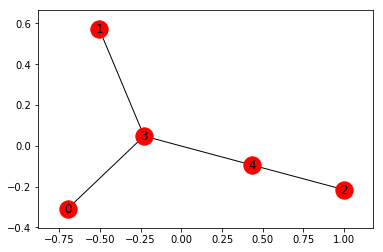

[(0, {'label': 'C'}), (1, {'label': 'C'}), (2, {'label': 'C'}), (3, {'label': 'C'}), (4, {'label': 'O'})]
 -> 


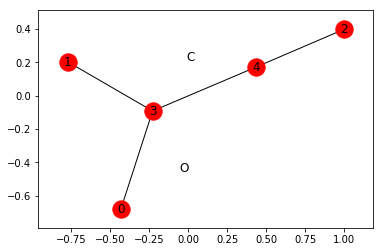

[(0, {'label': 'CC'}), (1, {'label': 'CC'}), (2, {'label': 'CO'}), (3, {'label': 'CCCO'}), (4, {'label': 'OCC'})]
 -> 


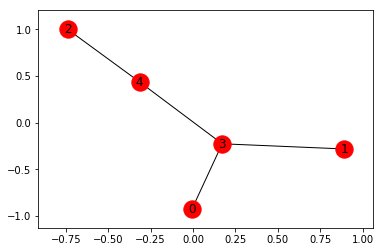

[(0, {'label': '0'}), (1, {'label': '0'}), (2, {'label': '3'}), (3, {'label': '1'}), (4, {'label': '2'})]


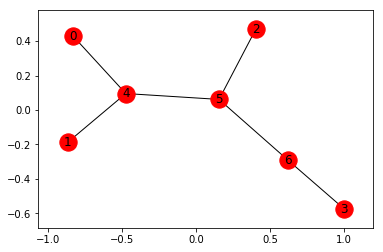

[(0, {'label': 'C'}), (1, {'label': 'C'}), (2, {'label': 'C'}), (3, {'label': 'C'}), (4, {'label': 'C'}), (5, {'label': 'C'}), (6, {'label': 'O'})]
 -> 


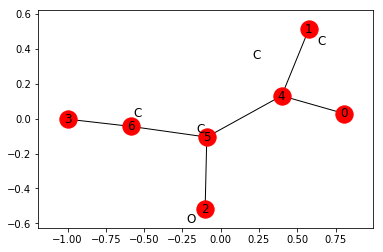

[(0, {'label': 'CC'}), (1, {'label': 'CC'}), (2, {'label': 'CC'}), (3, {'label': 'CO'}), (4, {'label': 'CCCC'}), (5, {'label': 'CCCO'}), (6, {'label': 'OCC'})]
 -> 


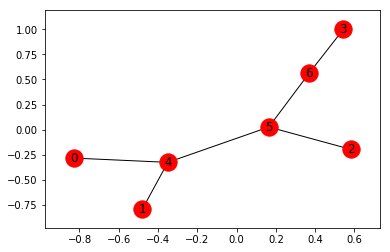

[(0, {'label': '0'}), (1, {'label': '0'}), (2, {'label': '0'}), (3, {'label': '3'}), (4, {'label': '4'}), (5, {'label': '1'}), (6, {'label': '2'})]
--- shortest path kernel built in 0.00026607513427734375 seconds ---
6


In [8]:
import sys
import networkx as nx
sys.path.insert(0, "../")
from pygraph.utils.graphfiles import loadDataset
from pygraph.kernels.spkernel import spkernel

import matplotlib.pyplot as plt


def weisfeilerlehman_test(G):
    '''
    Weisfeiler-Lehman test of graph isomorphism.
    '''

    nx.draw_networkx(G)
    plt.show()
    nx.draw_networkx_labels(G, nx.spring_layout(G), labels = nx.get_node_attributes(G,'label'))
    print(G.nodes(data = True))
    
    set_multisets = []
    for node in G.nodes(data = True):
        # Multiset-label determination.
        multiset = [ G.node[neighbors]['label'] for neighbors in G[node[0]] ]
        # sorting each multiset
        multiset.sort()
        multiset = node[1]['label'] + ''.join(multiset) # concatenate to a string and add the prefix 
        set_multisets.append(multiset)
        
    # label compression
#     set_multisets.sort() # this is unnecessary
    set_unique = list(set(set_multisets)) # set of unique multiset labels
    set_compressed = { value : str(set_unique.index(value)) for value in set_unique } # assign indices as the new labels
#     print(set_compressed)
#     print(set_multisets)
    
    # relabel nodes with multisets
    for node in G.nodes(data = True):
        node[1]['label'] = set_multisets[node[0]]
    print(' -> ')
    nx.draw_networkx(G)
    plt.show()
    print(G.nodes(data = True))

    
    # relabel nodes
    for node in G.nodes(data = True):
        node[1]['label'] = set_compressed[set_multisets[node[0]]]
        
    print(' -> ')
    nx.draw_networkx(G)
    plt.show()
    print(G.nodes(data = True))

dataset, y = loadDataset("../../../../datasets/acyclic/Acyclic/dataset_bps.ds")
G1 = dataset[12]
G2 = dataset[55]

# init.
kernel = 0 # init kernel
num_nodes1 = G1.number_of_nodes()
num_nodes2 = G2.number_of_nodes()

# the first iteration.
labelset1 = { G1.nodes(data = True)[i]['label'] for i in range(num_nodes1) }
labelset2 = { G2.nodes(data = True)[i]['label'] for i in range(num_nodes2) }
print(labelset1)
print(labelset2)
kernel += spkernel(G1, G2)
print(kernel)



for height in range(0, min(num_nodes1, num_nodes2)): #Q how to determine the upper bound of the height?
    if labelset1 != labelset2:
        break
        
    # Weisfeiler-Lehman test of graph isomorphism.
    weisfeilerlehman_test(G1)
    weisfeilerlehman_test(G2)
    
    # calculate kernel
    kernel += spkernel(G1, G2)
    
    # get label sets of both graphs
    labelset1 = { G1.nodes(data = True)[i]['label'] for i in range(num_nodes1) }
    labelset2 = { G2.nodes(data = True)[i]['label'] for i in range(num_nodes2) }
#     print(labelset1)
#     print(labelset2)

print(kernel)

In [20]:
# test of WL subtree kernel on many graphs

import sys
import pathlib
from collections import Counter
sys.path.insert(0, "../")

import networkx as nx
import numpy as np
import time

from pygraph.kernels.spkernel import spkernel
from pygraph.kernels.pathKernel import pathkernel

def weisfeilerlehmankernel(*args, height = 0, base_kernel = 'subtree'):
    """Calculate Weisfeiler-Lehman kernels between graphs.
    
    Parameters
    ----------
    Gn : List of NetworkX graph
        List of graphs between which the kernels are calculated.
    /
    G1, G2 : NetworkX graphs
        2 graphs between which the kernel is calculated.
        
    height : subtree height
    
    base_kernel : base kernel used in each iteration of WL kernel
        the default base kernel is subtree kernel
        
    Return
    ------
    Kmatrix/Kernel : Numpy matrix/int
        Kernel matrix, each element of which is the Weisfeiler-Lehman kernel between 2 praphs. / Weisfeiler-Lehman Kernel between 2 graphs.
        
    Notes
    -----
    This function now supports WL subtree kernel and WL shortest path kernel.
    
    References
    ----------
    [1] Shervashidze N, Schweitzer P, Leeuwen EJ, Mehlhorn K, Borgwardt KM. Weisfeiler-lehman graph kernels. Journal of Machine Learning Research. 2011;12(Sep):2539-61.
    """
    if len(args) == 1: # for a list of graphs

#         print(args)
        start_time = time.time()
        
        # for WL subtree kernel
        if base_kernel == 'subtree':           
            Kmatrix = _wl_subtreekernel_do(args[0], height = height, base_kernel = 'subtree')
            
        # for WL edge kernel
        elif base_kernel == 'edge':
            print('edge')
            
        # for WL shortest path kernel
        elif base_kernel == 'sp':
            Gn = args[0]
            Kmatrix = np.zeros((len(Gn), len(Gn)))
            
            for i in range(0, len(Gn)):
                for j in range(i, len(Gn)):
                    Kmatrix[i][j] = _weisfeilerlehmankernel_do(Gn[i], Gn[j])
                    Kmatrix[j][i] = Kmatrix[i][j]

        print("\n --- Weisfeiler-Lehman %s kernel matrix of size %d built in %s seconds ---" % (base_kernel, len(args[0]), (time.time() - start_time)))
        
        return Kmatrix
        
    else: # for only 2 graphs
        
        start_time = time.time()
        
        # for WL subtree kernel
        if base_kernel == 'subtree':
            
            args = [args[0], args[1]]
#             print(args)
            kernel = _wl_subtreekernel_do(args, height = height, base_kernel = 'subtree')
            
        # for WL edge kernel
        elif base_kernel == 'edge':
            print('edge')
            
        # for WL shortest path kernel
        elif base_kernel == 'sp':
            

            kernel = _pathkernel_do(args[0], args[1])

        print("\n --- Weisfeiler-Lehman %s kernel built in %s seconds ---" % (base_kernel, time.time() - start_time))
        
        return kernel
    
    
def _weisfeilerlehmankernel_do(G1, G2):
    """Calculate Weisfeiler-Lehman kernels between 2 graphs. This kernel use shortest path kernel to calculate kernel between two graphs in each iteration.
    
    Parameters
    ----------
    G1, G2 : NetworkX graphs
        2 graphs between which the kernel is calculated.
        
    Return
    ------
    Kernel : int
        Weisfeiler-Lehman Kernel between 2 graphs.
    """
    
    # init.
    kernel = 0 # init kernel
    num_nodes1 = G1.number_of_nodes()
    num_nodes2 = G2.number_of_nodes()
    height = 12 #min(num_nodes1, num_nodes2)) #Q how to determine the upper bound of the height?
    
    # the first iteration.
    labelset1 = { G1.nodes(data = True)[i]['label'] for i in range(num_nodes1) }
    labelset2 = { G2.nodes(data = True)[i]['label'] for i in range(num_nodes2) }
    kernel += pathkernel(G1, G2) # change your base kernel here (and one more below)
    
    for h in range(0, height):
#         if labelset1 != labelset2:
#             break

        # Weisfeiler-Lehman test of graph isomorphism.
        relabel(G1)
        relabel(G2)

        # calculate kernel
        kernel += pathkernel(G1, G2) # change your base kernel here (and one more before)

        # get label sets of both graphs
        labelset1 = { G1.nodes(data = True)[i]['label'] for i in range(num_nodes1) }
        labelset2 = { G2.nodes(data = True)[i]['label'] for i in range(num_nodes2) }
    
    return kernel


def relabel(G):
    '''
    Relabel nodes in graph G in one iteration of the 1-dim. WL test of graph isomorphism.
    
    Parameters
    ----------
    G : NetworkX graph
        The graphs whose nodes are relabeled.
    '''
    
    # get the set of original labels
    labels_ori = list(nx.get_node_attributes(G, 'label').values())
    print(labels_ori)
    num_of_each_label = dict(Counter(labels_ori))
    print(num_of_each_label)
    num_of_labels = len(num_of_each_label)
    print(num_of_labels)
    
    set_multisets = []
    for node in G.nodes(data = True):
        # Multiset-label determination.
        multiset = [ G.node[neighbors]['label'] for neighbors in G[node[0]] ]
        # sorting each multiset
        multiset.sort()
        multiset = node[1]['label'] + ''.join(multiset) # concatenate to a string and add the prefix 
        set_multisets.append(multiset)
    print(set_multisets)
        
    # label compression
#     set_multisets.sort() # this is unnecessary
    set_unique = list(set(set_multisets)) # set of unique multiset labels
    print(set_unique)
    set_compressed = { value : str(set_unique.index(value) + num_of_labels + 1) for value in set_unique } # assign new labels
    print(set_compressed)
    
    # relabel nodes
#     nx.relabel_nodes(G, set_compressed, copy = False)
    for node in G.nodes(data = True):
        node[1]['label'] = set_compressed[set_multisets[node[0]]]
    print(nx.get_node_attributes(G, 'label'))

    # get the set of compressed labels
    labels_comp = list(nx.get_node_attributes(G, 'label').values())
    print(labels_comp)
    num_of_each_label.update(dict(Counter(labels_comp)))
    print(num_of_each_label)
    
    
def _wl_subtreekernel_do(*args, height = 0, base_kernel = 'subtree'):
    """Calculate Weisfeiler-Lehman subtree kernels between graphs.
    
    Parameters
    ----------
    Gn : List of NetworkX graph
        List of graphs between which the kernels are calculated.
        
    Return
    ------
    Kmatrix/Kernel : Numpy matrix/int
        Kernel matrix, each element of which is the Weisfeiler-Lehman kernel between 2 praphs.
    """
    
#     print(args)
    Gn = args[0]
#     print(Gn)

    Kmatrix = np.zeros((len(Gn), len(Gn)))
    all_num_of_labels_occured = 0 # number of the set of letters that occur before as node labels at least once in all graphs
    
    # initial for height = 0
    print('\n --- height = 0 --- ')
    all_labels_ori = set() # all unique orignal labels in all graphs in this iteration
    all_num_of_each_label = [] # number of occurence of each label in each graph in this iteration
    all_set_compressed = {} # a dictionary mapping original labels to new ones in all graphs in this iteration
    num_of_labels_occured = all_num_of_labels_occured # number of the set of letters that occur before as node labels at least once in all graphs

    # for each graph
    for idx, G in enumerate(Gn):
        # get the set of original labels
        print('\n --- for graph %d --- \n' % (idx))
        labels_ori = list(nx.get_node_attributes(G, 'label').values())
        print('labels_ori: %s' % (labels_ori))
        all_labels_ori.update(labels_ori)
        print('all_labels_ori: %s' % (all_labels_ori))
        num_of_each_label = dict(Counter(labels_ori)) # number of occurence of each label in graph
        print('num_of_each_label: %s' % (num_of_each_label))
        all_num_of_each_label.append(num_of_each_label)
        print('all_num_of_each_label: %s' % (all_num_of_each_label))
        num_of_labels = len(num_of_each_label) # number of all unique labels
        print('num_of_labels: %s' % (num_of_labels))
        

        all_labels_ori.update(labels_ori)
        print('all_labels_ori: %s' % (all_labels_ori))
        
    all_num_of_labels_occured += len(all_labels_ori)
    print('\n all_num_of_labels_occured: %s' % (all_num_of_labels_occured))
        
    # calculate subtree kernel with the 0th iteration and add it to the final kernel
    print('\n --- calculating kernel matrix ---')
    for i in range(0, len(Gn)):
        for j in range(i, len(Gn)):
            labels = set(list(all_num_of_each_label[i].keys()) + list(all_num_of_each_label[j].keys()))
            print('\n labels: %s' % (labels))
            vector1 = np.matrix([ (all_num_of_each_label[i][label] if (label in all_num_of_each_label[i].keys()) else 0) for label in labels ])
            vector2 = np.matrix([ (all_num_of_each_label[j][label] if (label in all_num_of_each_label[j].keys()) else 0) for label in labels ])
            print('vector1: %s' % (vector1))
            print('vector2: %s' % (vector2))
            Kmatrix[i][j] += np.dot(vector1, vector2.transpose())
            Kmatrix[j][i] = Kmatrix[i][j]
            print('Kmatrix: %s' % (Kmatrix))

    
    # iterate each height
    for h in range(1, height + 1):
        print('\n --- height = %d --- ' % (h))
        all_set_compressed = {} # a dictionary mapping original labels to new ones in all graphs in this iteration
        num_of_labels_occured = all_num_of_labels_occured # number of the set of letters that occur before as node labels at least once in all graphs
        all_labels_ori = set()
        all_num_of_each_label = []
        
        # for each graph
        for idx, G in enumerate(Gn):
#             # get the set of original labels
            print('\n --- for graph %d --- \n' % (idx))
#             labels_ori = list(nx.get_node_attributes(G, 'label').values())
#             print('labels_ori: %s' % (labels_ori))
#             num_of_each_label = dict(Counter(labels_ori)) # number of occurence of each label in graph
#             print('num_of_each_label: %s' % (num_of_each_label))
#             num_of_labels = len(num_of_each_label) # number of all unique labels
#             print('num_of_labels: %s' % (num_of_labels))
            
#             all_labels_ori.update(labels_ori)
#             print('all_labels_ori: %s' % (all_labels_ori))
#             #             num_of_labels_occured += num_of_labels #@todo not precise
#             num_of_labels_occured = all_num_of_labels_occured + len(all_labels_ori) + len(all_set_compressed)
#             print('num_of_labels_occured: %s' % (num_of_labels_occured))
            
            set_multisets = []
            for node in G.nodes(data = True):
                # Multiset-label determination.
                multiset = [ G.node[neighbors]['label'] for neighbors in G[node[0]] ]
                # sorting each multiset
                multiset.sort()
                multiset = node[1]['label'] + ''.join(multiset) # concatenate to a string and add the prefix 
                set_multisets.append(multiset)
            print('multiset: %s' % (set_multisets))

            # label compression
        #     set_multisets.sort() # this is unnecessary
            set_unique = list(set(set_multisets)) # set of unique multiset labels
            print('set_unique: %s' % (set_unique))
            # a dictionary mapping original labels to new ones. 
            set_compressed = {}
            # if a label occured before, assign its former compressed label, else assign the number of labels occured + 1 as the compressed label 
            for value in set_unique:
                if value in all_set_compressed.keys():
                    set_compressed.update({ value : all_set_compressed[value] })
                else:
                    set_compressed.update({ value : str(num_of_labels_occured + 1) })
                    num_of_labels_occured += 1
#             set_compressed = { value : (all_set_compressed[value] if value in all_set_compressed.keys() else str(set_unique.index(value) + num_of_labels_occured + 1)) for value in set_unique }
            print('set_compressed: %s' % (set_compressed))
            
            all_set_compressed.update(set_compressed)
            print('all_set_compressed: %s' % (all_set_compressed))
#             num_of_labels_occured += len(set_compressed) #@todo not precise
            print('num_of_labels_occured: %s' % (num_of_labels_occured))
            
            # relabel nodes
        #     nx.relabel_nodes(G, set_compressed, copy = False)
            for node in G.nodes(data = True):
                node[1]['label'] = set_compressed[set_multisets[node[0]]]
            print('\n compressed labels: %s' % (nx.get_node_attributes(G, 'label')))

            # get the set of compressed labels
            labels_comp = list(nx.get_node_attributes(G, 'label').values())
            print('labels_comp: %s' % (labels_comp))
            all_labels_ori.update(labels_comp)
            print('all_labels_ori: %s' % (all_labels_ori))
            num_of_each_label = dict(Counter(labels_comp))
            print('num_of_each_label: %s' % (num_of_each_label))
            all_num_of_each_label.append(num_of_each_label)
            print('all_num_of_each_label: %s' % (all_num_of_each_label))
                    
        all_num_of_labels_occured += len(all_labels_ori)
        print('\n all_num_of_labels_occured: %s' % (all_num_of_labels_occured))
        
        # calculate subtree kernel with h iterations and add it to the final kernel
        print('\n --- calculating kernel matrix ---')
        for i in range(0, len(Gn)):
            for j in range(i, len(Gn)):
                labels = set(list(all_num_of_each_label[i].keys()) + list(all_num_of_each_label[j].keys()))
                print('\n labels: %s' % (labels))
                vector1 = np.matrix([ (all_num_of_each_label[i][label] if (label in all_num_of_each_label[i].keys()) else 0) for label in labels ])
                vector2 = np.matrix([ (all_num_of_each_label[j][label] if (label in all_num_of_each_label[j].keys()) else 0) for label in labels ])
                print('vector1: %s' % (vector1))
                print('vector2: %s' % (vector2))
                Kmatrix[i][j] += np.dot(vector1, vector2.transpose())
                Kmatrix[j][i] = Kmatrix[i][j]
                    
        print('\n Kmatrix: %s' % (Kmatrix))

    return Kmatrix

    
# main
import sys
from collections import Counter
import networkx as nx
sys.path.insert(0, "../")
from pygraph.utils.graphfiles import loadDataset
from pygraph.kernels.spkernel import spkernel

dataset, y = loadDataset("../../../../datasets/acyclic/Acyclic/dataset_bps.ds")
G1 = dataset[15]
print(nx.get_node_attributes(G1, 'label'))
G2 = dataset[80]
print(nx.get_node_attributes(G2, 'label'))

weisfeilerlehmankernel(G1, G2, height = 2)
# Kmatrix = weisfeilerlehmankernel(G1, G2)

{0: 'C', 1: 'C', 2: 'C', 3: 'C', 4: 'C', 5: 'O', 6: 'O'}
{0: 'C', 1: 'C', 2: 'C', 3: 'C', 4: 'C', 5: 'C', 6: 'S', 7: 'S'}

 --- height = 0 --- 

 --- for graph 0 --- 

labels_ori: ['C', 'C', 'C', 'C', 'C', 'O', 'O']
all_labels_ori: {'C', 'O'}
num_of_each_label: {'C': 5, 'O': 2}
all_num_of_each_label: [{'C': 5, 'O': 2}]
num_of_labels: 2
all_labels_ori: {'C', 'O'}

 --- for graph 1 --- 

labels_ori: ['C', 'C', 'C', 'C', 'C', 'C', 'S', 'S']
all_labels_ori: {'C', 'O', 'S'}
num_of_each_label: {'C': 6, 'S': 2}
all_num_of_each_label: [{'C': 5, 'O': 2}, {'C': 6, 'S': 2}]
num_of_labels: 2
all_labels_ori: {'C', 'O', 'S'}

 all_num_of_labels_occured: 3

 --- calculating kernel matrix ---

 labels: {'C', 'O'}
vector1: [[5 2]]
vector2: [[5 2]]
Kmatrix: [[ 29.   0.]
 [  0.   0.]]

 labels: {'C', 'O', 'S'}
vector1: [[5 2 0]]
vector2: [[6 0 2]]
Kmatrix: [[ 29.  30.]
 [ 30.   0.]]

 labels: {'C', 'S'}
vector1: [[6 2]]
vector2: [[6 2]]
Kmatrix: [[ 29.  30.]
 [ 30.  40.]]

 --- height = 1 --- 

 --- for 

array([[ 55.,  36.],
       [ 36.,  72.]])

In [4]:

len(dataset)

185

In [1]:
# Author: Elisabetta Ghisu
# test of WL subtree kernel

"""
- This script take as input a kernel matrix
and returns the classification or regression performance
- The kernel matrix can be calculated using any of the graph kernels approaches
- The criteria used for prediction are SVM for classification and kernel Ridge regression for regression
- For predition we divide the data in training, validation and test. For each split, we first train on the train data, 
then evaluate the performance on the validation. We choose the optimal parameters for the validation set and finally
provide the corresponding performance on the test set. If more than one split is performed, the final results 
correspond to the average of the performances on the test sets. 

@references
    https://github.com/eghisu/GraphKernels/blob/master/GraphKernelsCollection/python_scripts/compute_perf_gk.py
"""

print(__doc__)

import sys
import os
import pathlib
sys.path.insert(0, "../")
from tabulate import tabulate

import random
import numpy as np
import matplotlib.pyplot as plt

from sklearn.kernel_ridge import KernelRidge # 0.17
from sklearn.metrics import accuracy_score, mean_squared_error
from sklearn import svm

from pygraph.kernels.weisfeilerLehmanKernel import weisfeilerlehmankernel
from pygraph.utils.graphfiles import loadDataset

val_means_height = []
val_stds_height = []
test_means_height = []
test_stds_height = []


for height in np.linspace(0, 10, 11):
    print('\n --- calculating kernel matrix when subtree height = %d ---' % height)

    print('\n Loading dataset from file...')
    dataset, y = loadDataset("../../../../datasets/acyclic/Acyclic/dataset_bps.ds")
    y = np.array(y)
    print(y)

    # setup the parameters
    model_type = 'regression' # Regression or classification problem
    print('\n --- This is a %s problem ---' % model_type)

    datasize = len(dataset)
    trials = 100 # Trials for hyperparameters random search
    splits = 10 # Number of splits of the data
    alpha_grid = np.logspace(-10, 10, num = trials, base = 10) # corresponds to (2*C)^-1 in other linear models such as LogisticRegression
    C_grid = np.logspace(-10, 10, num = trials, base = 10)
    random.seed(20) # Set the seed for uniform parameter distribution

    # set the output path
    kernel_file_path = 'kernelmatrices_weisfeilerlehman_acyclic/'
    if not os.path.exists(kernel_file_path):
        os.makedirs(kernel_file_path)


    """
    -  Here starts the main program
    -  First we permute the data, then for each split we evaluate corresponding performances
    -  In the end, the performances are averaged over the test sets
    """

    # save kernel matrices to files / read kernel matrices from files
    kernel_file = kernel_file_path + 'km.ds'
    path = pathlib.Path(kernel_file)
    # get train set kernel matrix
    if path.is_file():
        print('\n Loading the kernel matrix from file...')
        Kmatrix = np.loadtxt(kernel_file)
        print(Kmatrix)
    else:
        print('\n Calculating kernel matrix, this could take a while...')
        Kmatrix = weisfeilerlehmankernel(dataset, node_label = 'atom', height = int(height), base_kernel = 'sp')
        print(Kmatrix)
        print('\n Saving kernel matrix to file...')
#         np.savetxt(kernel_file, Kmatrix)

    # Initialize the performance of the best parameter trial on validation with the corresponding performance on test
    val_split = []
    test_split = []

    # For each split of the data
    for j in range(10, 10 + splits):
    #         print('\n Starting split %d...' % j)

        # Set the random set for data permutation
        random_state = int(j)
        np.random.seed(random_state)
        idx_perm = np.random.permutation(datasize)
    #     print(idx_perm)

        # Permute the data
        y_perm = y[idx_perm] # targets permutation
    #     print(y_perm)
        Kmatrix_perm = Kmatrix[:, idx_perm] # inputs permutation
    #     print(Kmatrix_perm)
        Kmatrix_perm = Kmatrix_perm[idx_perm, :] # inputs permutation

        # Set the training, validation and test
        # Note: the percentage can be set up by the user
        num_train_val = int((datasize * 90) / 100)         # 90% (of entire dataset) for training and validation
        num_test = datasize - num_train_val              # 10% (of entire dataset) for test
        num_train = int((num_train_val * 90) / 100) # 90% (of train + val) for training
        num_val = num_train_val - num_train # 10% (of train + val) for validation

        # Split the kernel matrix
        Kmatrix_train = Kmatrix_perm[0:num_train, 0:num_train]
        Kmatrix_val = Kmatrix_perm[num_train:(num_train + num_val), 0:num_train]
        Kmatrix_test = Kmatrix_perm[(num_train + num_val):datasize, 0:num_train]

        # Split the targets
        y_train = y_perm[0:num_train]

        # Normalization step (for real valued targets only)
        if model_type == 'regression':
    #             print('\n Normalizing output y...')
            y_train_mean = np.mean(y_train)
            y_train_std = np.std(y_train)
            y_train = (y_train - y_train_mean) / float(y_train_std)
    #         print(y)

        y_val = y_perm[num_train:(num_train + num_val)]
        y_test = y_perm[(num_train + num_val):datasize]

        # Record the performance for each parameter trial respectively on validation and test set
        perf_all_train = []
        perf_all_test = []

        # For each parameter trial
        for i in range(trials):
            # For regression use the Kernel Ridge method
            if model_type == 'regression':
    #             print('\n Starting experiment for trial %d and parameter alpha = %3f\n ' % (i, alpha_grid[i]))

                # Fit the kernel ridge model
                KR = KernelRidge(kernel = 'precomputed', alpha = alpha_grid[i])
    #                 KR = svm.SVR(kernel = 'precomputed', C = C_grid[i])
                KR.fit(Kmatrix_train, y_train)

                # predict on the validation and test set
                y_pred = KR.predict(Kmatrix_val)
                y_pred_test = KR.predict(Kmatrix_test)
    #             print(y_pred)

                # adjust prediction: needed because the training targets have been normalizaed
                y_pred = y_pred * float(y_train_std) + y_train_mean
    #             print(y_pred)
                y_pred_test = y_pred_test * float(y_train_std) + y_train_mean
    #             print(y_pred_test)

                # root mean squared error on validation
                rmse = np.sqrt(mean_squared_error(y_val, y_pred))
                perf_all_val.append(rmse)

                # root mean squared error in test 
                rmse_test = np.sqrt(mean_squared_error(y_test, y_pred_test))
                perf_all_test.append(rmse_test)

    #             print('The performance on the validation set is: %3f' % rmse)
    #             print('The performance on the test set is: %3f' % rmse_test)

        # --- FIND THE OPTIMAL PARAMETERS --- #
        # For regression: minimise the mean squared error
        if model_type == 'regression':

            # get optimal parameter on validation (argmin mean squared error)
            min_idx = np.argmin(perf_all_test)
            alpha_opt = alpha_grid[min_idx]

            # performance corresponding to optimal parameter on val
            perf_val_opt = perf_all_val[min_idx]

            # corresponding performance on test for the same parameter
            perf_test_opt = perf_all_test[min_idx]

    #             print('The best performance is for trial %d with parameter alpha = %3f' % (min_idx, alpha_opt))
    #             print('The best performance on the validation set is: %3f' % perf_val_opt)
    #             print('The corresponding performance on test set is: %3f' % perf_test_opt)

        # append the best performance on validation
        # at the current split
        val_split.append(perf_val_opt)

        # append the correponding performance on the test set
        test_split.append(perf_test_opt)

    # average the results
    # mean of the validation performances over the splits
    val_mean = np.mean(np.asarray(val_split))
    # std deviation of validation over the splits
    val_std = np.std(np.asarray(val_split))

    # mean of the test performances over the splits
    test_mean = np.mean(np.asarray(test_split))
    # std deviation of the test oer the splits
    test_std = np.std(np.asarray(test_split))

    print('\n Mean performance on val set: %3f' % val_mean)
    print('With standard deviation: %3f' % val_std)
    print('\n Mean performance on test set: %3f' % test_mean)
    print('With standard deviation: %3f' % test_std)
    
    val_means_height.append(val_mean)
    val_stds_height.append(val_std)
    test_means_height.append(test_mean)
    test_stds_height.append(test_std)
    
print('\n') 
print(tabulate({'height': np.linspace(1, 12, 11), 'RMSE': test_means_height, 'std': test_stds_height}, headers='keys'))


- This script take as input a kernel matrix
and returns the classification or regression performance
- The kernel matrix can be calculated using any of the graph kernels approaches
- The criteria used for prediction are SVM for classification and kernel Ridge regression for regression
- For predition we divide the data in training, validation and test. For each split, we first train on the train data, 
then evaluate the performance on the validation. We choose the optimal parameters for the validation set and finally
provide the corresponding performance on the test set. If more than one split is performed, the final results 
correspond to the average of the performances on the test sets. 

@references
    https://github.com/eghisu/GraphKernels/blob/master/GraphKernelsCollection/python_scripts/compute_perf_gk.py


 --- calculating kernel matrix when subtree height = 0 ---

 Loading dataset from file...
[ -23.7   14.    37.3  109.7   10.8   39.    42.    66.6  135.   148.5
   40.    34

KeyboardInterrupt: 

In [15]:
# a = [0, 1, 3, 2]
# b = [3, 2, 1, 0]
# print(1 if a == b else 0)

# max(1 ,2)

# x = [ 'r', 'a', 's' ]
# x.sort()
# print(x)

# def test1(*args, base = 'subtree'):
#     if base == 'subtree':
#         print('subtree')
#     elif base == 'edge':
#         print('edge')
#     else:
#         print('sp')

# # function parameter usage test
# test1('hello', 'hi', base = 'edge')

# # python matrix calculation speed test
# import numpy as np
# import time

# size = 100
# m1 = np.random.random((size, size))
# m2 = np.random.random((size, size))
# itr = 1

# start_time = time.time()
# for i in range(itr):
#     np.dot(m1, m2)
# print(time.time() - start_time)

# start_time = time.time()
# for j in range(itr):
#     result = np.zeros((size, size))
#     for i1 in range(size):
#         for i2 in range(size):
#             for i3 in range(size):
#                 result[i1][i2] += m1[i1][i3] * m2[i3][i2]
# print(time.time() - start_time)

# start_time = time.time()
# for i in range(itr):
#     print(np.dot(m1, m2))
# print(time.time() - start_time)

# start_time = time.time()
# for j in range(itr):
#     result = np.zeros((size, size))
#     for i1 in range(size):
#         for i2 in range(size):
#             for i3 in range(size):
#                 result[i1][i2] += m1[i1][i3] * m2[i3][i2]
#     print(result)
# print(time.time() - start_time)

# help(np.sum)

# test dict
import sys
from collections import Counter
import networkx as nx
sys.path.insert(0, "../")
from pygraph.utils.graphfiles import loadDataset
from pygraph.kernels.spkernel import spkernel

dataset, y = loadDataset("../../../../datasets/acyclic/Acyclic/dataset_bps.ds")
G1 = dataset[15]
nx.get_node_attributes(G1, 'label')
listhqhq = list(nx.get_node_attributes(G1, 'label').values())
dicthaha = dict(Counter(listhqhq))
len(dicthaha)

{0: 'C', 1: 'C', 2: 'C', 3: 'C', 4: 'C', 5: 'O', 6: 'O'}